In [1]:
import MySQLdb
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline
plt.style.use('ggplot')

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)

######################################################################################


# We'll use this to adjust for inflation to 2017 USD
filepath = "../inflation.csv"
inflation = pd.read_csv(filepath)

inflation['DATE'] = pd.to_datetime(inflation.DATE)

funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

# Make this a datetime and a little clean up
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_at'] = df_funding.funded_at.apply(lambda x: x.replace(day=1))

# Wayyyy too many funding codes. Let's put them into something a little simpler
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 
                                          'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 
                                          'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 
                                          'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 
                                          'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

# Much better. Let's get rid of this then.
del df_funding['funding_round_code']


# To be combined with a later dataframe
objects_string = """
SELECT id, normalized_name, name, category_code, status, founded_at, closed_at, 
funding_rounds, funding_total_usd FROM cb_objects
"""
df_objects = pd.read_sql(objects_string, con=conn)
df_objects['sector'] = df_objects['category_code']
del df_objects['category_code']

# Let's scale this
df_funding.raised_amount_usd /= df_funding.groupby(['funded_object_id', 
                                                    'funded_at']).raised_amount_usd.transform('count')
# To be used for timing
df_funding_timing = df_funding.merge(df_objects[['id', 'sector']], left_on='funded_object_id', right_on='id')




high_level = df_funding_timing.groupby(['funded_at']).agg({'raised_amount_usd': 'sum', 'funding_round_id': 'count'})
high_level = high_level.iloc[-108:].reset_index()
high_level.rename(columns={'funding_round_id':'number_of_investments'}, inplace=True)

adjusted_high_level = high_level.merge(inflation, left_on='funded_at', right_on='DATE')
adjusted_high_level.rename(columns={'CPIAUCSL_NBD20170101':'inflation'}, inplace=True)
del adjusted_high_level['DATE']
adjusted_high_level['num_diff'] = adjusted_high_level.number_of_investments.diff()

adjusted_high_level['current_USD']=adjusted_high_level.raised_amount_usd*(100/adjusted_high_level.inflation)
adjusted_high_level['rolling_annual_USD'] = adjusted_high_level.current_USD.rolling(window=12).mean()
adjusted_high_level['log_USD'] = np.log1p(adjusted_high_level.current_USD)
adjusted_high_level['minus_one'] = adjusted_high_level.log_USD.diff()
adjusted_high_level['rolling_annual_log_USD'] = adjusted_high_level.log_USD.rolling(window=12).mean()

In [25]:
adjusted_high_level.tail()

,funded_at,raised_amount_usd,number_of_investments,inflation,num_diff,current_USD,rolling_annual_USD,log_USD,minus_one,rolling_annual_log_USD,shifted,diff_y,seasonal_diff,log_MA
103,2013-08-01,3.948181e+09,1272,95.56230,-213.0,4.131526e+09,4.179591e+09,22.141913,-0.611938,22.106943,22.192939,-0.118576,-0.730514,0.034969
104,2013-09-01,6.434671e+09,1485,95.68886,213.0,6.724577e+09,4.467611e+09,22.629035,0.487122,22.167067,21.759340,-0.433599,0.053523,0.461967
105,2013-10-01,5.740101e+09,1558,95.72408,73.0,5.996507e+09,4.687001e+09,22.514443,-0.114592,22.215242,21.907546,0.148206,0.033615,0.299201
106,2013-11-01,6.161524e+09,1305,95.88914,-253.0,6.425675e+09,4.838860e+09,22.583567,0.069124,22.243035,21.936346,0.028799,0.097924,0.340532
107,2013-12-01,2.877650e+09,566,96.13570,-739.0,2.993321e+09,4.896077e+09,21.819649,-0.763918,22.264748,22.250054,0.313708,-0.450210,-0.445099


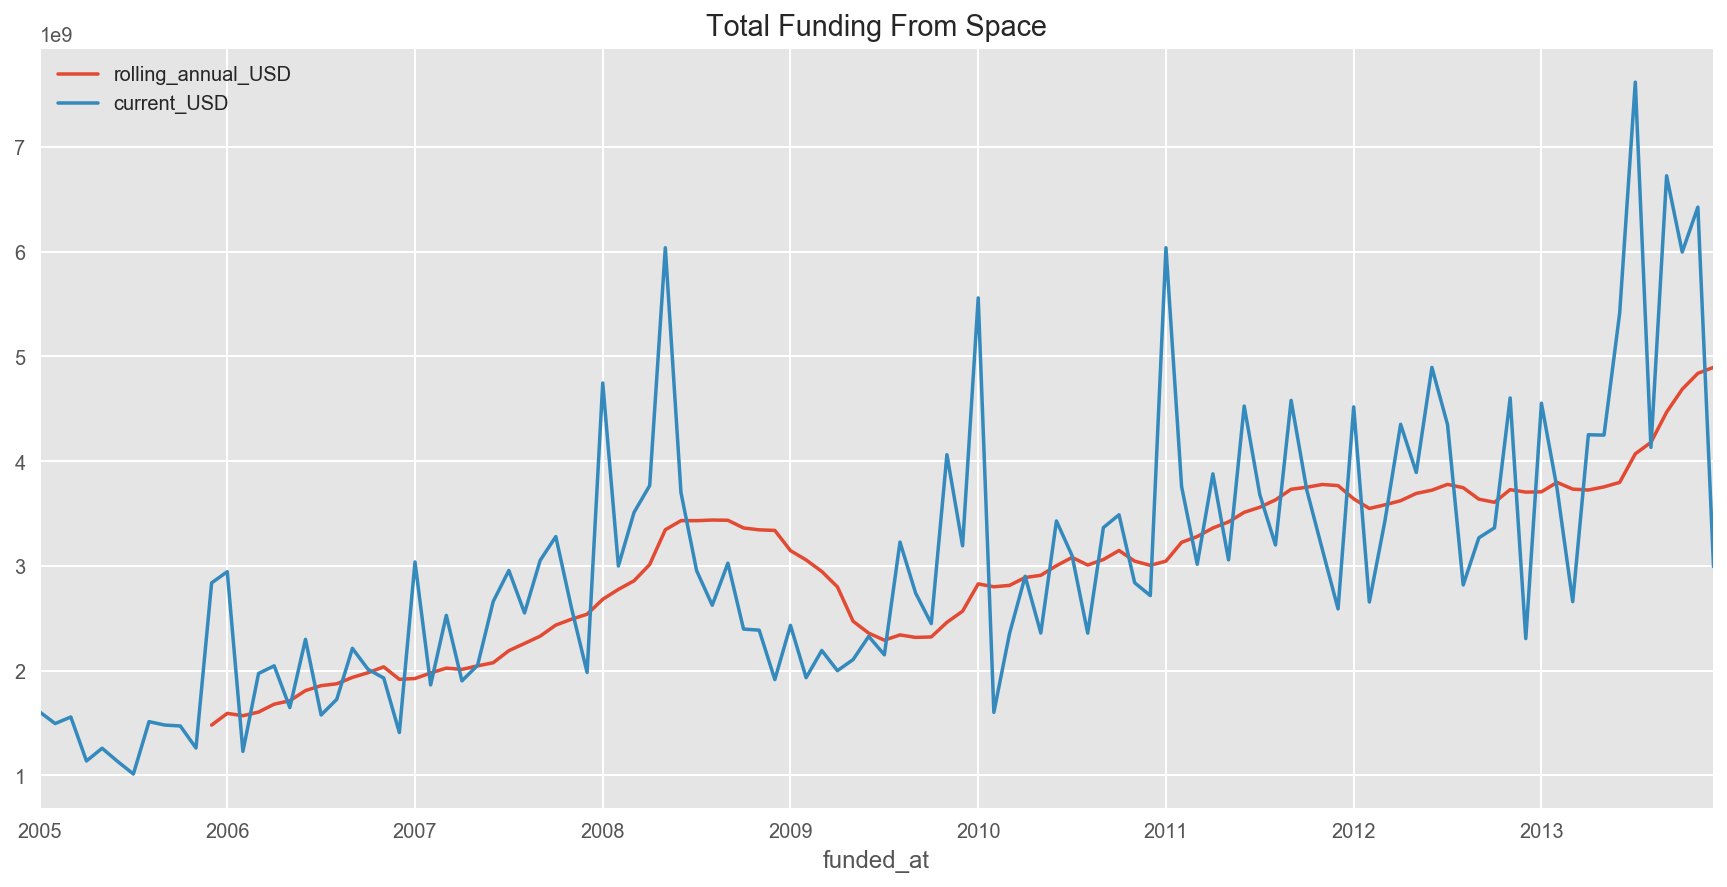

In [342]:
adjusted_high_level.plot(x='funded_at',y=['rolling_annual_USD','current_USD'],figsize=(15,7),title='Total Funding From Space')

## Predicting Funding Amount

In [37]:
adjusted_high_level.tail(14)

,funded_at,raised_amount_usd,number_of_investments,inflation,num_diff,current_USD,rolling_annual_USD,log_USD,minus_one,rolling_annual_log_USD,shifted,diff_y,seasonal_diff,log_MA
94,2012-11-01,4.359980e+09,1073,94.71285,-294.0,4.603367e+09,3.728140e+09,22.250054,0.313708,22.016396,22.038312,-0.206763,0.106945,0.233658
95,2012-12-01,2.184496e+09,923,94.70138,-150.0,2.306720e+09,3.704557e+09,21.559093,-0.690961,22.006753,21.872098,-0.166214,-0.857175,-0.447660
96,2013-01-01,4.319493e+09,1349,94.86152,426.0,4.553472e+09,3.707477e+09,22.239156,0.680063,22.007397,21.674813,-0.197285,0.482778,0.231759
97,2013-02-01,3.566877e+09,1062,95.42386,-287.0,3.737930e+09,3.797690e+09,22.041798,-0.197358,22.035892,22.231431,0.556619,0.359261,0.005906
98,2013-03-01,2.529708e+09,1210,95.14290,148.0,2.658851e+09,3.733173e+09,21.701160,-0.340638,22.014596,21.699852,-0.531579,-0.872217,-0.313436
99,2013-04-01,4.037055e+09,1319,94.93648,109.0,4.252375e+09,3.724859e+09,22.170743,0.469584,22.012663,21.956715,0.256863,0.726447,0.158080
100,2013-05-01,4.035673e+09,1243,94.98603,-76.0,4.248702e+09,3.754558e+09,22.169879,-0.000864,22.019964,22.193935,0.237220,0.236356,0.149915
101,2013-06-01,5.150274e+09,1364,95.17362,121.0,5.411451e+09,3.797581e+09,22.411783,0.241904,22.028320,22.082270,-0.111665,0.130238,0.383463
102,2013-07-01,7.266909e+09,1485,95.38455,121.0,7.618539e+09,4.070142e+09,22.753850,0.342067,22.075062,22.311515,0.229246,0.571313,0.678788
103,2013-08-01,3.948181e+09,1272,95.56230,-213.0,4.131526e+09,4.179591e+09,22.141913,-0.611938,22.106943,22.192939,-0.118576,-0.730514,0.034969


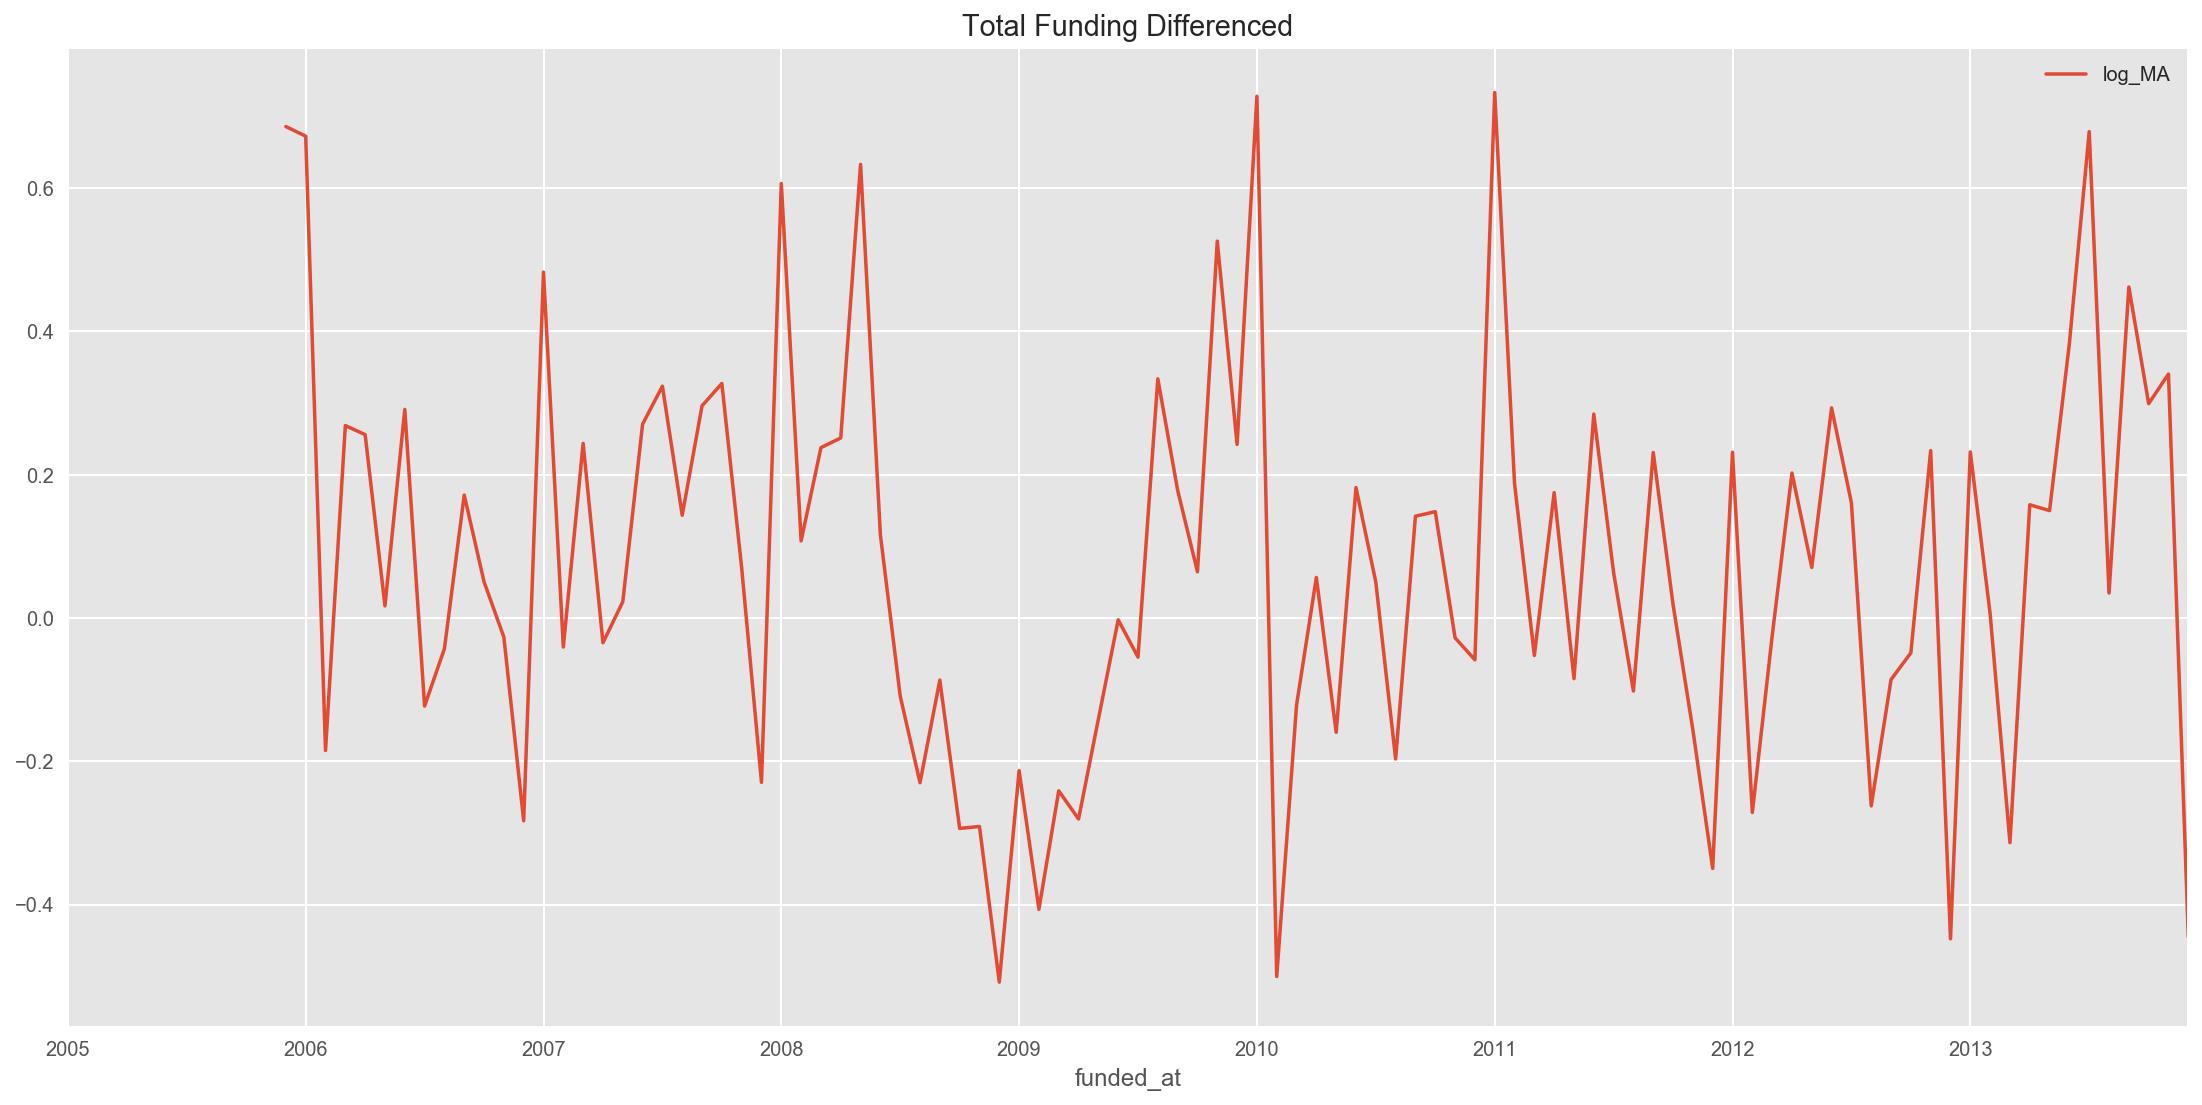

In [60]:
adjusted_high_level['shifted'] = adjusted_high_level.log_USD.shift(periods=13)
adjusted_high_level['diff_y'] = adjusted_high_level.shifted.diff()

# This 'seasonal' amount is from the Duke website given: Ŷt  =  (Yt-1) + (Yt-12) – (Yt-13)
adjusted_high_level['seasonal_diff'] = adjusted_high_level.minus_one + adjusted_high_level.diff_y

# From Analytics Vidhya
adjusted_high_level['log_MA'] = adjusted_high_level['log_USD'] - adjusted_high_level['rolling_annual_log_USD']

adjusted_high_level.plot(x='funded_at',y=['seasonal_diff'],figsize=(19,9),title='Total Funding Differenced')

In [77]:
adjusted_high_level.index = adjusted_high_level['funded_at'].values

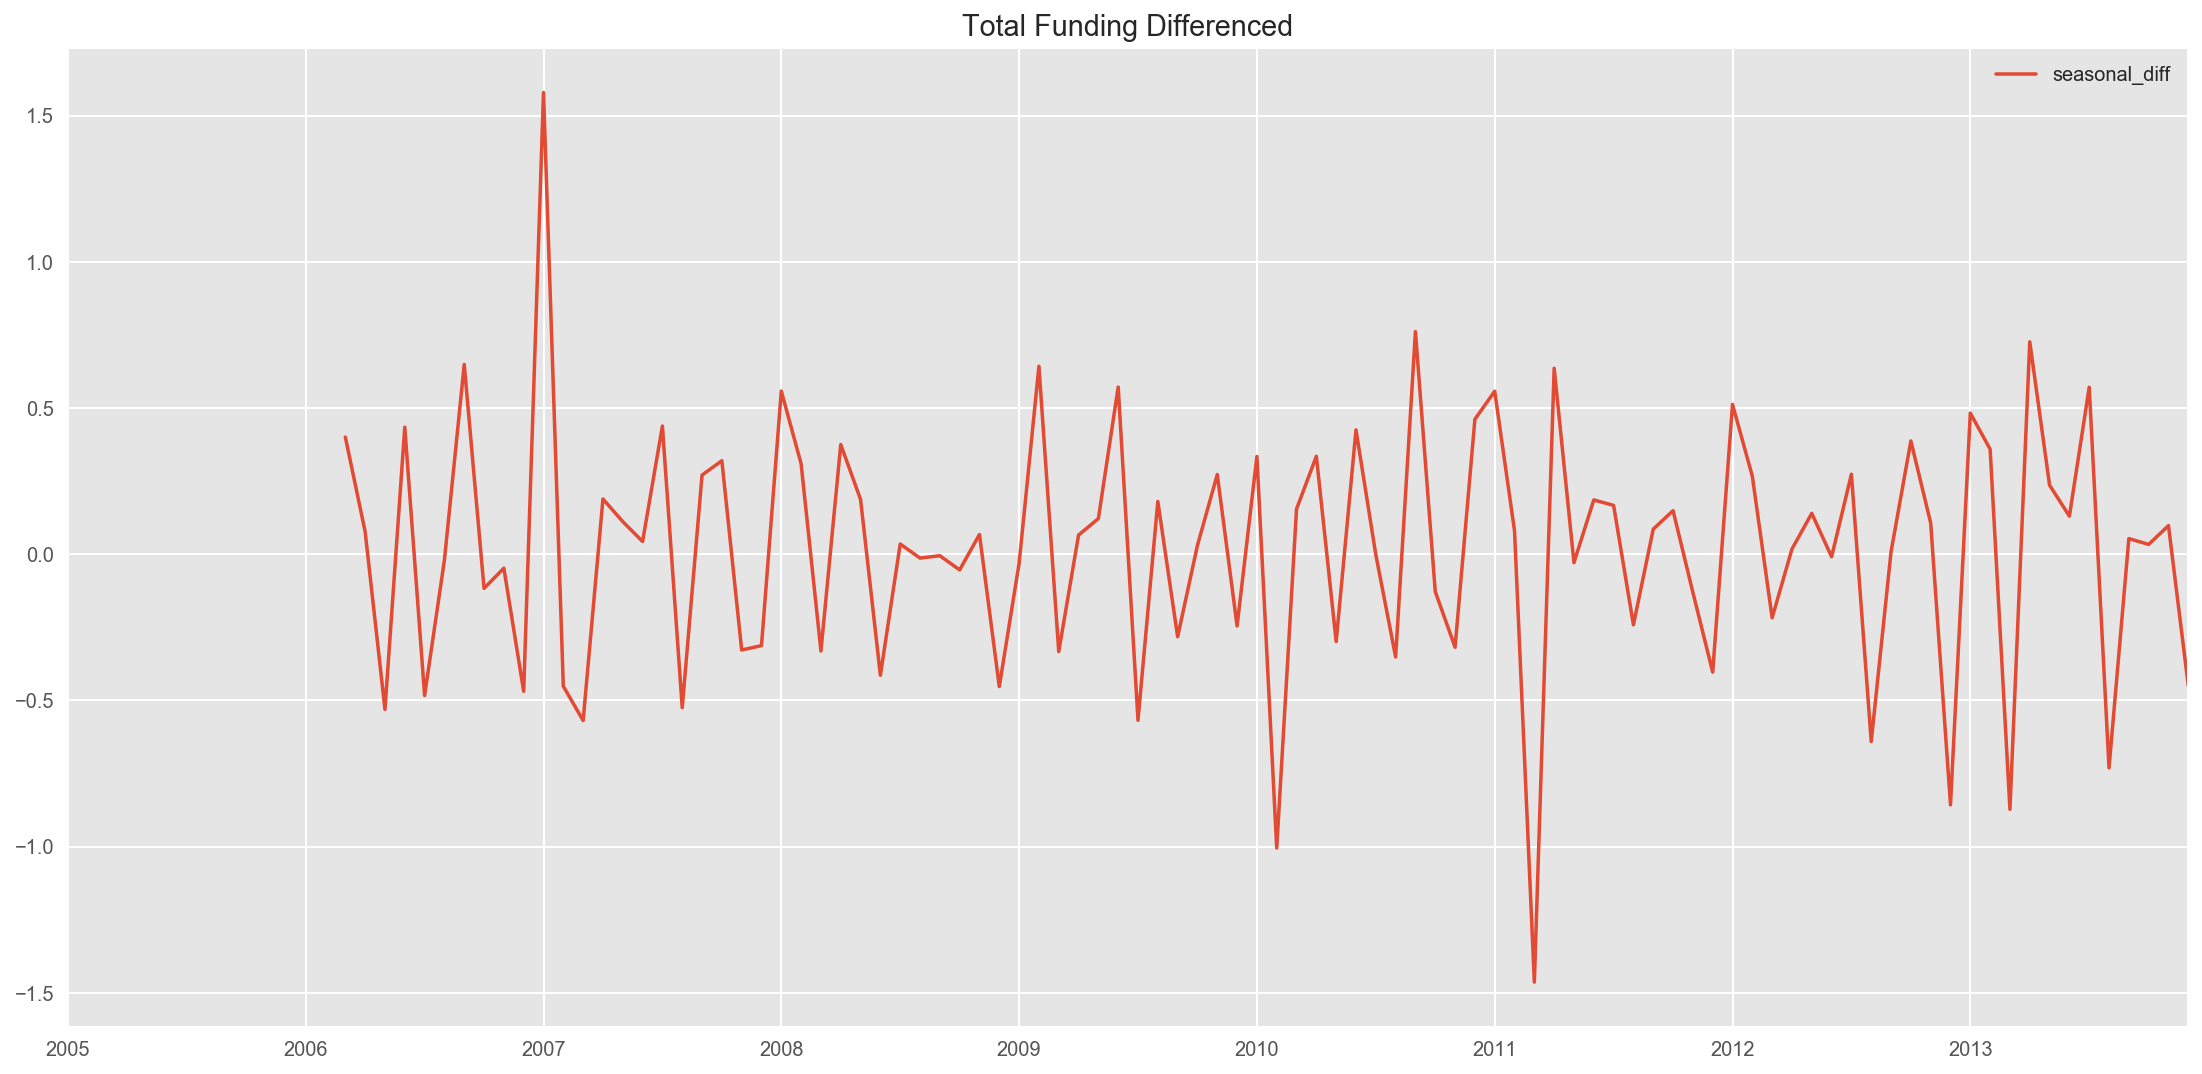

In [78]:
adjusted_high_level.plot(y=['seasonal_diff'],figsize=(19,9),title='Total Funding Differenced')

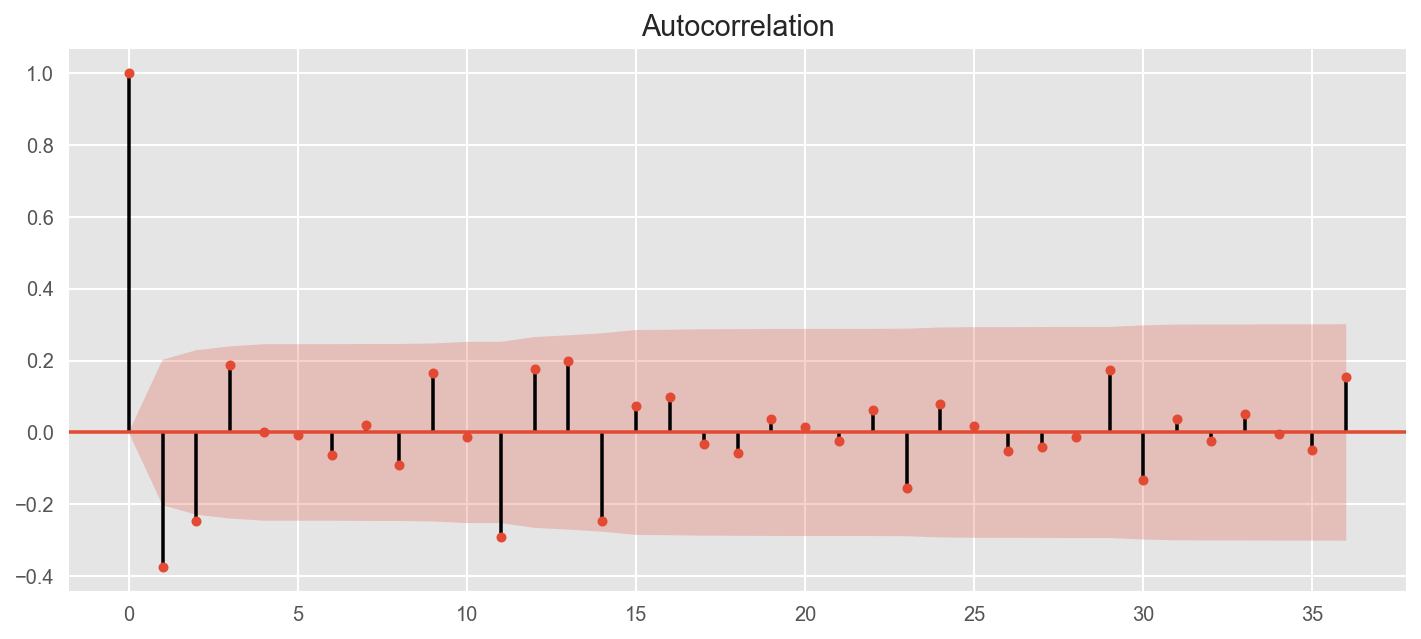

In [64]:
udiff = adjusted_high_level['seasonal_diff']
# udiff.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=36, ax=ax)
plt.show()

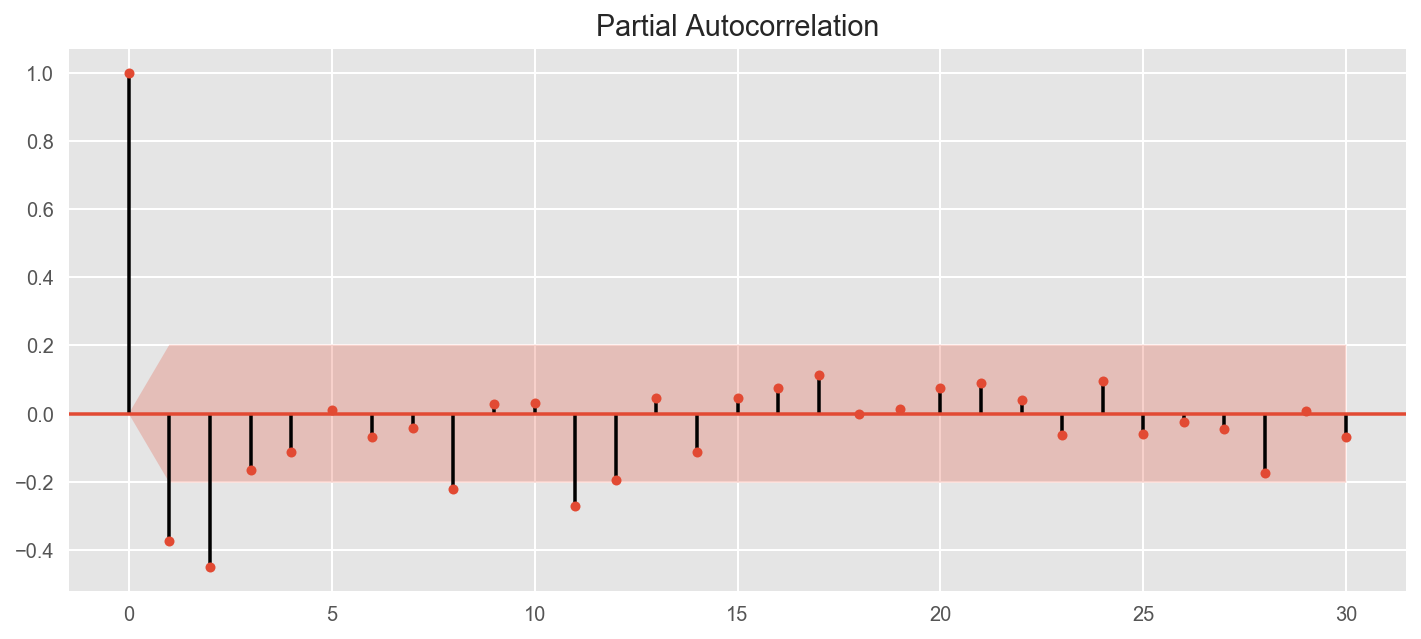

In [65]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=30, ax=ax)
plt.show()

In [76]:
ar5 = ARMA(udiff.values, (5, 5)).fit()
print "R squared: ", r2_score(udiff, ar5.fittedvalues)

R squared:  0.451509315584


In [80]:
# Best r2 score for ARMA from 5,5 and best AIC/BIC for ARIMA 4,1
import pyflux as pf
pf_ar5 = pf.ARIMA(data=adjusted_high_level.seasonal_diff.values, ar=5, ma=5, family=pf.Normal())
pf_ar5_results = pf_ar5.fit("MLE")
pf_ar5_results.summary()

KeyError: '[             nan              nan              nan              nan\n              nan              nan              nan              nan\n              nan              nan              nan              nan\n              nan              nan   4.00726833e-01   7.71752459e-02\n  -5.30635434e-01   4.34605890e-01  -4.83366907e-01  -1.99739312e-02\n   6.48995650e-01  -1.16748157e-01  -4.78808828e-02  -4.68773280e-01\n   1.57894890e+00  -4.51489326e-01  -5.68791733e-01   1.88908450e-01\n   1.11617501e-01   4.35130542e-02   4.38557739e-01  -5.24790339e-01\n   2.70566346e-01   3.19874433e-01  -3.27565594e-01  -3.12535115e-01\n   5.58191190e-01   3.09174340e-01  -3.30975085e-01   3.75235808e-01\n   1.87391657e-01  -4.14018876e-01   3.50271389e-02  -1.31468776e-02\n  -5.10980684e-03  -5.36144118e-02   6.74890798e-02  -4.52665952e-01\n  -3.13774814e-02   6.42842248e-01  -3.33025555e-01   6.55192165e-02\n   1.21822386e-01   5.71720904e-01  -5.67900747e-01   1.80514875e-01\n  -2.82233356e-01   3.04131057e-02   2.72633345e-01  -2.45452646e-01\n   3.34517157e-01  -1.00465980e+00   1.54565274e-01   3.35204962e-01\n  -2.98621507e-01   4.25293637e-01  -1.47993604e-03  -3.51408429e-01\n   7.61447496e-01  -1.27870366e-01  -3.18073523e-01   4.61718502e-01\n   5.57425315e-01   8.03023881e-02  -1.46350140e+00   6.36046170e-01\n  -2.88451347e-02   1.85674042e-01   1.67001338e-01  -2.41363113e-01\n   8.57079828e-02   1.49096268e-01  -1.30411284e-01  -4.03244227e-01\n   5.12558297e-01   2.66863849e-01  -2.17468649e-01   1.77358598e-02\n   1.39875175e-01  -8.77604024e-03   2.73712786e-01  -6.40525400e-01\n   8.41954583e-03   3.87420349e-01   1.06945095e-01  -8.57175174e-01\n   4.82777825e-01   3.59260513e-01  -8.72217269e-01   7.26446738e-01\n   2.36355841e-01   1.30238428e-01   5.71313245e-01  -7.30514358e-01\n   5.35231788e-02   3.36145817e-02   9.79239293e-02  -4.50210070e-01] not in index'

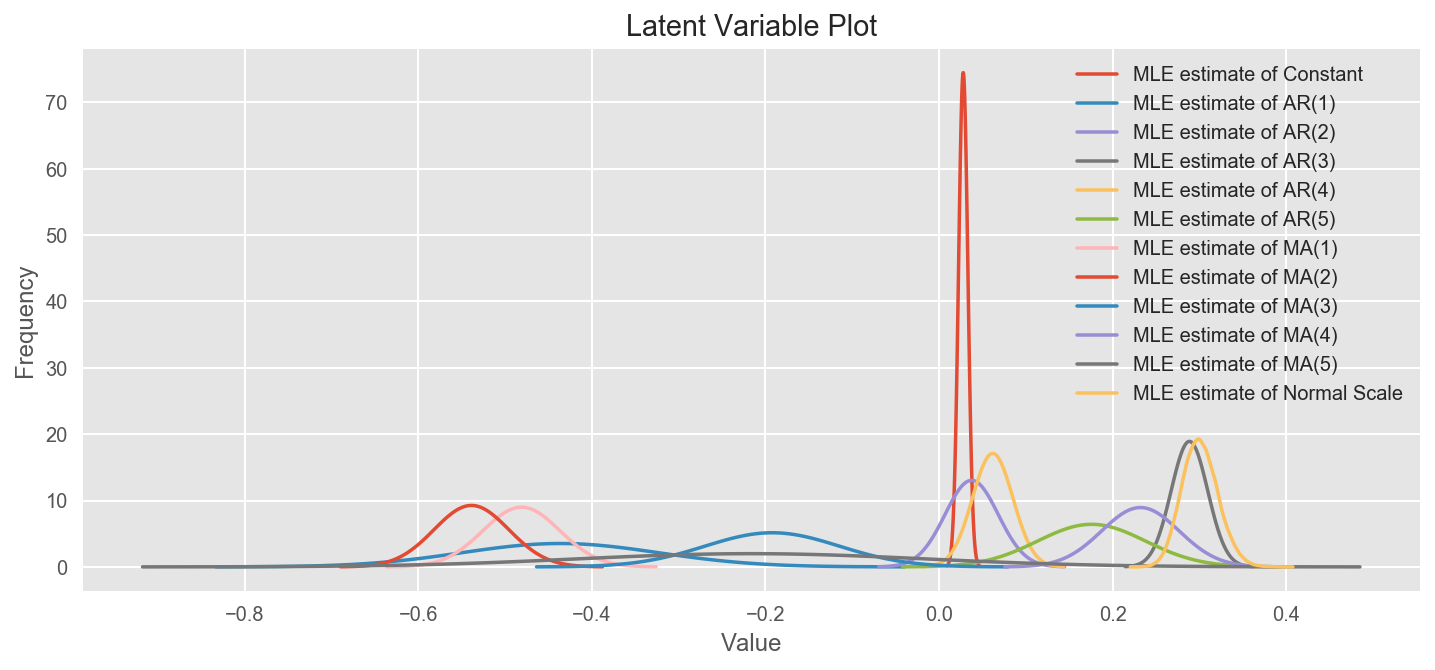

In [68]:
pf_ar5.plot_z(figsize=(12,5))

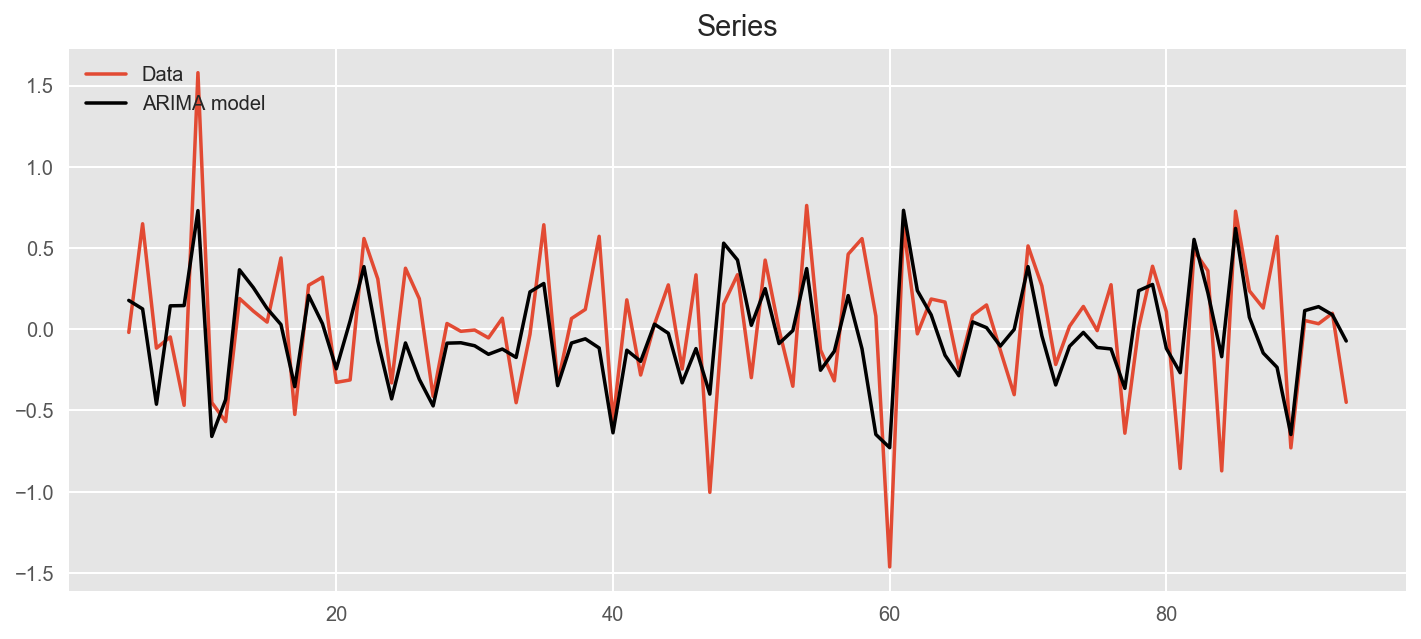

In [75]:
pf_ar5.plot_fit(h=12,past_values=24,figsize=(12,5))

In [70]:
pf_ar5.predict(h=12)

,Series
94,0.313029
95,0.104272
96,-0.026453
97,0.033350
98,0.064216
99,0.054750
100,0.032558
101,0.031528
102,0.040823
103,0.035163


In [72]:
ar5_df = pf_ar5.predict(h=12).reset_index()

In [73]:
ar5_df['merge_col'] = ar5_df['index'] + 14
ar5_df = ar5_df.set_index(ar5_df.merge_col.values)

In [74]:
adjusted_high_level.append(ar5_df)

,Series,current_USD,diff_y,funded_at,index,inflation,log_MA,log_USD,merge_col,minus_one,num_diff,number_of_investments,raised_amount_usd,rolling_annual_USD,rolling_annual_log_USD,seasonal_diff,shifted
0,NaN,1.607392e+09,NaN,2005-01-01,NaN,78.47378,NaN,21.197879,NaN,NaN,NaN,439.0,1.261381e+09,NaN,NaN,NaN,NaN
1,NaN,1.495108e+09,NaN,2005-02-01,NaN,78.80143,NaN,21.125464,NaN,-0.072415,-167.0,272.0,1.178166e+09,NaN,NaN,NaN,NaN
2,NaN,1.557594e+09,NaN,2005-03-01,NaN,79.08813,NaN,21.166408,NaN,0.040944,86.0,358.0,1.231872e+09,NaN,NaN,NaN,NaN
3,NaN,1.137798e+09,NaN,2005-04-01,NaN,79.33387,NaN,20.852360,NaN,-0.314048,-36.0,322.0,9.026588e+08,NaN,NaN,NaN,NaN
4,NaN,1.259300e+09,NaN,2005-05-01,NaN,79.29292,NaN,20.953822,NaN,0.101462,9.0,331.0,9.985358e+08,NaN,NaN,NaN,NaN
5,NaN,1.132403e+09,NaN,2005-06-01,NaN,79.33387,NaN,20.847608,NaN,-0.106214,-16.0,315.0,8.983791e+08,NaN,NaN,NaN,NaN
6,NaN,1.013422e+09,NaN,2005-07-01,NaN,79.82536,NaN,20.736598,NaN,-0.111009,-63.0,252.0,8.089677e+08,NaN,NaN,NaN,NaN
7,NaN,1.513429e+09,NaN,2005-08-01,NaN,80.31684,NaN,21.137644,NaN,0.401045,156.0,408.0,1.215538e+09,NaN,NaN,NaN,NaN
8,NaN,1.480894e+09,NaN,2005-09-01,NaN,81.42269,NaN,21.115912,NaN,-0.021731,-18.0,390.0,1.205784e+09,NaN,NaN,NaN,NaN
9,NaN,1.471917e+09,NaN,2005-10-01,NaN,81.54556,NaN,21.109831,NaN,-0.006081,-6.0,384.0,1.200283e+09,NaN,NaN,NaN,NaN


## Number of Investments

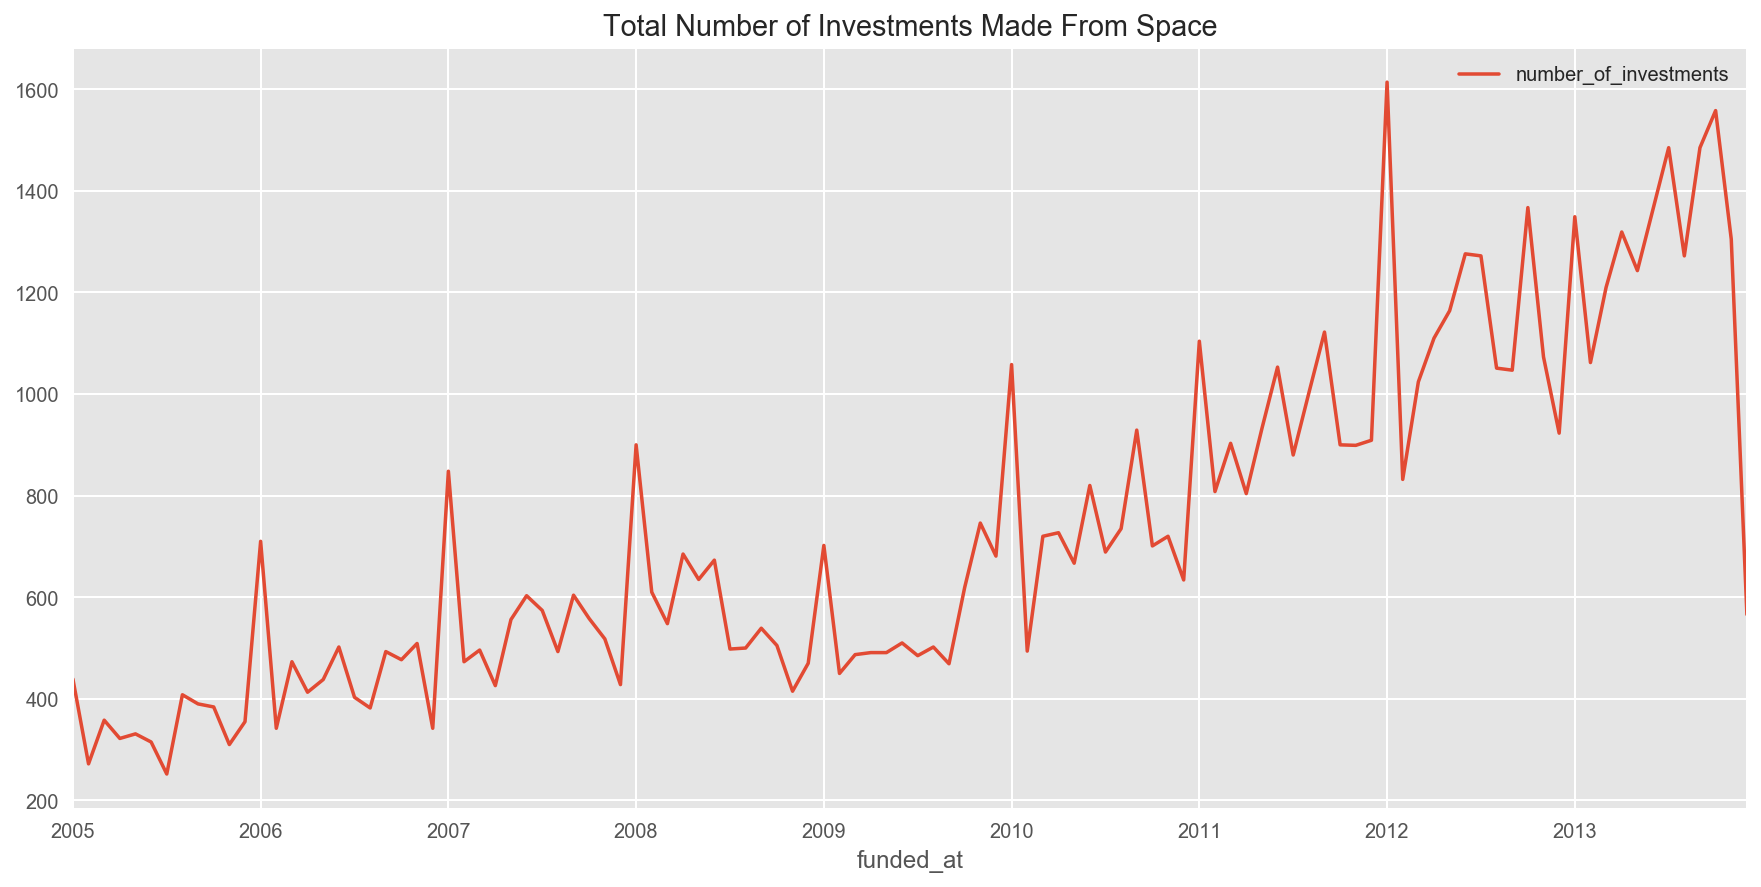

In [16]:
adjusted_high_level.plot(x='funded_at',y=['number_of_investments'],figsize=(15,7),title='Total Number of Investments Made From Space')



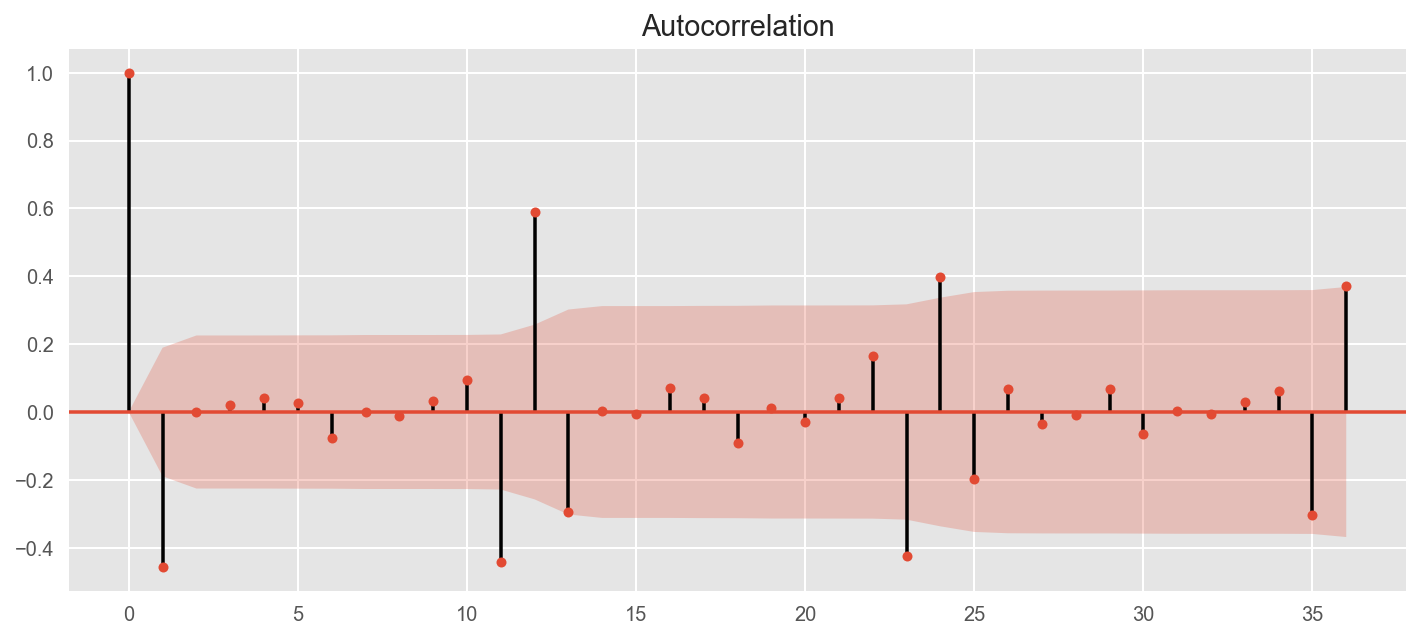

In [259]:
ndiff = adjusted_high_level['num_diff']
ndiff.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(ndiff.values, lags=36, ax=ax)
plt.show()

count    107.000000
mean       1.186916
std      217.087893
min     -782.000000
25%      -78.500000
50%        4.000000
75%      116.000000
max      705.000000
Name: num_diff, dtype: float64